# Study of the results of the NN for the torus

This notebook studies the results of the NN trained to predict PI from the torus dataset. 
   1. We compare the regression results between a classifier trained on real PIs and trained on predicted PIs.
   2. we look at the p-values of the Kolmogorov-Smirnov test on each pixels,
   

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from IPython.display import SVG

import gudhi as gd
import gudhi.representations

from tqdm import tqdm
from time import time

from scipy.stats import ks_2samp
from sklearn.metrics import r2_score


### Load the NN

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 500, 3)]          0         
_________________________________________________________________
fully_connected2_4 (FullyCon (None, 500, 50)           150       
_________________________________________________________________
tf.nn.relu_4 (TFOpLambda)    (None, 500, 50)           0         
_________________________________________________________________
dense_27 (Dense)             (None, 500, 35)           1785      
_________________________________________________________________
dense_28 (Dense)             (None, 500, 20)           720       
_________________________________________________________________
dense_29 (Dense)             (None, 500, 10)           210       
_________________________________________________________________
lambda_4 (Lambda)            (None, 10)                0   

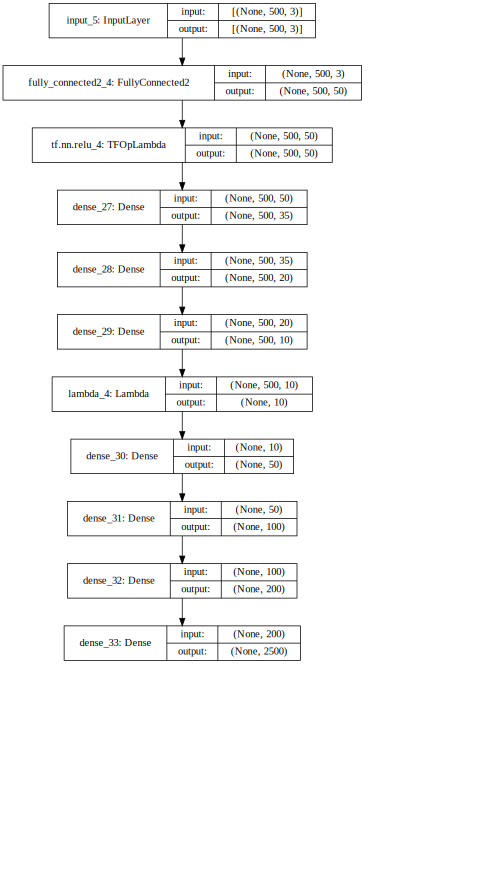

In [2]:
model_PI = tf.keras.models.load_model('../Trained_NN/model_torus/')
model_PI.summary()

SVG(
    tf.keras.utils.model_to_dot(model_PI,
                                show_shapes=True).create(prog='dot',
                                                         format='svg'))
#tf.keras.utils.plot_model(model_PI,
#to_file='dot_img_file.pdf',
#show_shapes=True,
#rankdir='LR')

## Regression

We first load the data that will be used as training and testing data for the regression for the radii.

In [3]:
data = np.load('data/PI_data_torus_reg.npz')

#data = np.load('PI_data_1000_dynamical_alpha.npz')

data_train = data["data_train"]
r_train_gudhi = data["r_train"]
R_train_gudhi = data["R_train"]
PI_train_gudhi = data["PI_train"]

data_test = data["data_test"]
r_test_gudhi = data["r_test"]
R_test_gudhi = data["R_test"]
PI_test_gudhi = data["PI_test"]

PI_train_gudhi /= max(np.max(PI_train_gudhi), np.max(PI_test_gudhi))
PI_test_gudhi /= max(np.max(PI_train_gudhi), np.max(PI_test_gudhi))

In [4]:
N_sets_train = r_train_gudhi.shape[0]
N_sets_test = r_test_gudhi.shape[0]
PI_size = int(np.sqrt(PI_train_gudhi.shape[1]))
N_points = data_train.shape[1]

In [5]:
print("N_sets_train : ", N_sets_train)
print("N_sets_test : ", N_sets_test)
print("PI_size : ", PI_size)

N_sets_train :  2000
N_sets_test :  200
PI_size :  50


In [6]:
radii_train = np.stack((r_train_gudhi,R_train_gudhi),1)
radii_test = np.stack((r_test_gudhi,R_test_gudhi),1)

We want to compare the regression results between the true PIs and the predited PIs. For that, we create 2 models : ```model_reg_NN``` will be trained with the PI computed by the NN and ```model_reg_gudhi``` will be trained with the PI computed by Gudhi. We will then compare their accuracy on new data.

In [7]:
def create_model():
    inputs = tf.keras.Input(shape=(PI_size * PI_size))

    x = tf.keras.layers.Dense(100, activation='relu')(inputs)

    x = tf.keras.layers.Dense(50, activation='relu')(x)

    outputs = tf.keras.layers.Dense(2)(x)

    model_reg = tf.keras.Model(inputs=inputs, outputs=outputs)
    model_reg.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
    return model_reg

In [9]:
model_reg_NN = create_model()
model_reg_gudhi = create_model()

model_reg_NN.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2500)]            0         
_________________________________________________________________
dense (Dense)                (None, 100)               250100    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total params: 255,252
Trainable params: 255,252
Non-trainable params: 0
_________________________________________________________________


### Fit the regression model ```model_regression_gudhi```

In [10]:
history_gudhi = model_reg_gudhi.fit(PI_train_gudhi,
                            radii_train,
                            epochs=100,
                            validation_data=(PI_test_gudhi, radii_test))

Epoch 1/100
63/63 [==============================] - 1s 4ms/step - loss: 2.2473 - mean_squared_error: 2.2473 - val_loss: 0.3058 - val_mean_squared_error: 0.3058
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.1413 - mean_squared_error: 0.1413 - val_loss: 0.3116 - val_mean_squared_error: 0.3116
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0931 - mean_squared_error: 0.0931 - val_loss: 0.3129 - val_mean_squared_error: 0.3129
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0645 - mean_squared_error: 0.0645 - val_loss: 0.2282 - val_mean_squared_error: 0.2282
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.2301 - val_mean_squared_error: 0.2301
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0372 - mean_squared_error: 0.0372 - val_loss: 0.2152 - val_mean_squared_error: 0.2152
Epoch 7/100
63/63 [===============

We compute the $R^2$ coefficient and the MSE score of the regression trained on real PIs. 

In [12]:
radii_predicted_gudhi = model_reg_gudhi.predict(PI_test_gudhi)
test_loss, test_acc = model_reg_gudhi.evaluate(PI_test_gudhi,  radii_test, verbose=2)
r2 = r2_score(radii_test,radii_predicted_gudhi)
print("r2 = ",r2)


7/7 - 0s - loss: 0.0844 - mean_squared_error: 0.0844
0.6630692592136469


We plot the regression for both radii trained on true PIs.

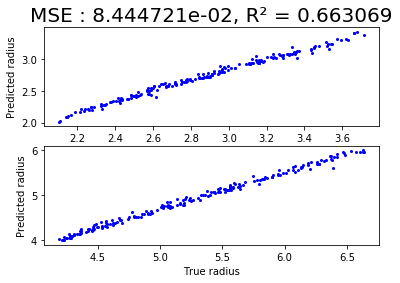

In [14]:
plt.subplot(2,1,1)
plt.plot(radii_predicted_gudhi[:,0],radii_test[:,0],'bo',markersize=2)
plt.xlabel("True radius")
plt.ylabel("Predicted radius")
plt.title("MSE : {:e}, R² = {:2f}".format(test_acc,r2),fontsize=20)

plt.subplot(2,1,2)
plt.plot(radii_predicted_gudhi[:,1],radii_test[:,1],'bo',markersize=2)
plt.xlabel("True radius")
plt.ylabel("Predicted radius")
#plt.title("MSE : {:e}, R² = {:2f}".format(test_acc,r2),fontsize=20)

plt.savefig("Résultats/Résultats 4/regression_radii_torus_gudhi.pdf")

 ### Generate data for the training of ```model_reg_NN```  

In [15]:
PI_train_NN = model_PI.predict(data_train)

In [16]:
PI_test_NN = model_PI.predict(data_test)

### Fit the regression model ```model_reg_NN```

In [17]:
history_NN = model_reg_NN.fit(PI_train_NN,
                            radii_train,
                            epochs=50,
                            validation_data=(PI_test_NN, radii_test))

Epoch 1/50
63/63 [==============================] - 0s 4ms/step - loss: 3.0902 - mean_squared_error: 3.0902 - val_loss: 0.2019 - val_mean_squared_error: 0.2019
Epoch 2/50
63/63 [==============================] - 0s 3ms/step - loss: 0.1280 - mean_squared_error: 0.1280 - val_loss: 0.1025 - val_mean_squared_error: 0.1025
Epoch 3/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0684 - mean_squared_error: 0.0684 - val_loss: 0.0599 - val_mean_squared_error: 0.0599
Epoch 4/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0387 - mean_squared_error: 0.0387 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 5/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - val_loss: 0.0224 - val_mean_squared_error: 0.0224
Epoch 6/50
63/63 [==============================] - 0s 3ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.0177 - val_mean_squared_error: 0.0177
Epoch 7/50
63/63 [======================

In [18]:
test_loss, test_acc = model_reg_NN.evaluate(PI_test_NN,  radii_test, verbose=2)

print('\nMSE:', test_acc)

7/7 - 0s - loss: 0.0040 - mean_squared_error: 0.0040

MSE: 0.004014887847006321


### We generated test data for ```model_reg_NN ```

In [ ]:
def create_torus(N_points, r, R):
    X = np.zeros((N_points, 3))
    for i in range(N_points):
        theta = np.random.random() * 2 * np.pi
        phi = np.random.random() * 2 * np.pi
        X[i, 0] = (R + r * np.cos(theta)) * np.cos(phi)
        X[i, 1] = (R + r * np.cos(theta)) * np.sin(phi)
        X[i, 2] = r * np.sin(theta)
        #X[i] = [x,y,z]
    return np.array(X)


In [24]:
data_test = np.zeros((200,N_points,3))
r_test = np.zeros((200,))
R_test = np.zeros((200,))
for i in tqdm(range(200), desc='Generating dataset : '):
    R = np.random.uniform(4, 6)
    r = np.random.uniform(R / 2, (R + 1) / 2)
    data_test[i] = create_torus(N_points, r, R)
    R_test[i] = R
    r_test[i] = r
radii_test = np.stack((r_test,R_test),1)

Generating dataset : 100%|██████████| 200/200 [00:00<00:00, 320.69it/s]


In [25]:
PI_test = model_PI.predict(data_test)

We compute the $R^2$ coefficient and the MSE score of the regression trained on predicted PIs. 

In [26]:
radii_predicted_NN = model_reg_NN.predict(PI_test)
test_loss, test_acc = model_reg_NN.evaluate(PI_test,  radii_test, verbose=2)
r2 = r2_score(radii_test,radii_predicted_NN)


7/7 - 0s - loss: 0.0028 - mean_squared_error: 0.0028


We plot the regression trained on predicted PIs.

Text(0, 0.5, 'Predicted radius')

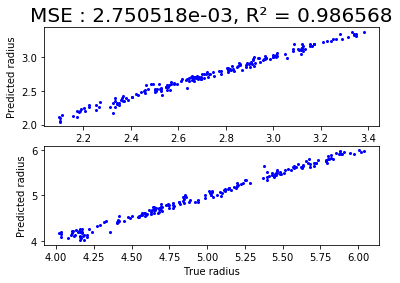

In [27]:
plt.subplot(2,1,1)
plt.plot(radii_predicted_NN[:,0],r_test,'bo',markersize=2)
plt.xlabel("True radius")
plt.ylabel("Predicted radius")
plt.title("MSE : {:e}, R² = {:2f}".format(test_acc,r2),fontsize=20)

plt.subplot(2,1,2)
plt.plot(radii_predicted_NN[:,1],R_test,'bo',markersize=2)
plt.xlabel("True radius")
plt.ylabel("Predicted radius")
#plt.title("MSE : {:e}, R² = {:2f}".format(test_acc,r2),fontsize=20)


#plt.savefig("Résultats/Résultats 4/regression_radii_torus_NN.pdf")